#**MICN**: multi-scale local and global context modeling for long-term series forecasting


In [55]:
import torch
import math
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

 The implemented model is trained and tested on a dataset containing the **electricity consumption** of **321 customers** recorded **hourly from 2012 to 2014**. The dataset is a *csv* file having as first column the date `(year-month-day hour:minutes:seconds)`, then 321 columns corresponding to the customers consumption and a final column *OT*, that is a target whose value summarizes all the 321 corresponding consumptions in case the forecasting type is *univariate predict univariate* or *multivariate predict univariate*.

In [56]:
data_path = 'electricity.csv'

forecasting_types=['M','MS']
forecasting_type = 'M' #multivariate predict multivariate
target = 'OT'

learning_rate = 0.0005
batch_size = 32
patience = 3
input_length = 96
w_len = 48
output_length = 96
features_len = 321

decomposition_kernel=[33]
convolutional_kernel=[12, 24]
isometric_kernel=[18, 6]

**Dataset class for data loading and preprocessing**

*   data loading
*   normalization of the features of each data series entry
*   extraction from the date column of the temporal features (like **month, day, hour**) and then scaling to values **from -0.5 to 0.5**
*   creation of a separate dataframe containing only these scaled temporal features
*   splitting of the dataset into **training set (70%)**, **validation set (10%)** and **test set (20%)**.
*   extraction of a sub-sequence (size 144) that acts like a unit sample. The first 96 observations are used as **x** for training (together with the corresponding timestamps). The last 96 observations are used as ground truth **y** (together with the corresponding timestamps) that are the ones that the model should predict. There's an overlapping between the last 48 features of **x** and the first 48 features of **y**, used as a temporal sliding window in order to capture temporal dependencies and patterns in the data effectively.

The input features $X \in R^{I \times d}$. The corresponding timestamp is $X_{ts} \in R^{I \times 3}$.

The output we want to predict is $Y \in R^{O \times d}$. The corresponding timestamp is $Y_{ts} \in R^{O \times 3}$.




In [57]:
class ElectricityDataset(Dataset):

  def __init__(self, data_path,flag,input_length,output_length,window_len,forecasting_type,target='OT'):
      original_df = pd.read_csv(data_path)

      self.in_len = input_length
      self.window_len = window_len
      self.out_len = output_length

      # Choose targets based on forecasting type
      if forecasting_type=='M' or forecasting_type=='MS':
        # consider all the features
        features = original_df.columns[1:] #take all the columns of the original df except the first
        data = original_df[features]
      elif forecasting_type=='S':
        # conider only the target column
        data = original_df[target]

      # Standard normalization of features
      scaler = StandardScaler()
      scaler.fit(data)
      data= scaler.transform(data)
      data= pd.DataFrame(data)

      # Extract the month, day and hour in a separate dataset
      self.dataset_ts=pd.DataFrame()
      original_df['date'] = pd.to_datetime(original_df['date'])

      self.dataset_ts['month'] = original_df['date'].dt.month
      self.dataset_ts['day'] = original_df['date'].dt.day
      self.dataset_ts['hour'] = original_df['date'].dt.hour

      # Scaling month, day and hour to a value between [-0.5,0.5]
      self.scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
      self.dataset_ts[['month', 'day', 'hour']] = self.scaler.fit_transform(self.dataset_ts[['month', 'day', 'hour']])

      # Define splitting sizes:
      train_size = int(len(data)*0.7)
      val_size = int(len(data)*0.1)
      test_size = int(len(data)*0.2)

      # Load desired dataset range based on dataset flag:
      if flag=='train':
        data_range=[0, train_size]
      elif flag=='val':
        data_range=[train_size-self.in_len, train_size+val_size]
      else:
        data_range=[len(data)-test_size-self.in_len, len(data)]

      # Take X Dataset in a selected range:
      self.dataset_x=data.iloc[data_range[0]:data_range[1]+1]

      #Take Y dataset in a selected range:
      self.dataset_y=data.iloc[data_range[0]:data_range[1]+1]

      #Take temporal reference in a selected range
      self.dataset_ts=self.dataset_ts.iloc[data_range[0]:data_range[1]+1]

  def __getitem__(self, index):
        #Define units length for batch training extraction
        x_begin = index
        x_end = x_begin + self.in_len
        y_begin = x_end - self.window_len
        y_end = y_begin + self.out_len

        # take X,y related features
        x = torch.tensor(self.dataset_x[x_begin:x_end].values,dtype=torch.float32)
        y = torch.tensor(self.dataset_y[y_begin:y_end].values,dtype=torch.float32)

        # Take Related data stamp referee for the X,y datasets
        x_ts = torch.tensor(self.dataset_ts[x_begin:x_end].values,dtype=torch.float32)
        y_ts = torch.tensor(self.dataset_ts[y_begin:y_end].values,dtype=torch.float32)

        return x, y, x_ts, y_ts

  def __len__(self):
        return len(self.dataset_x) - self.in_len - self.window_len +1


##**MULTI-SCALE HYBRID DECOMPOSITION**

This module returns the ***seasonal*** part and ***trend-cyclical*** part of the input data. It computes the moving average to smooth out periodic fluctuations and highlight the long-term trends.  This block uses several **different kernels** for the ***Avgpool(·)*** operations and separates several different patterns of trend-cyclical and seasonal parts purposefully:

$$X_t = mean(AvgPool(Padding(X))_{kernel_1},...,AvgPool(Padding(X))_{kernel_n})$$

\
$$X_s = X −X_t$$

In [58]:
class moving_average(nn.Module):  #AvgPool(Padding(X),kernel)
    def __init__(self, kernel_size):
        super(moving_average, self).__init__()
        self.kernel_size = kernel_size
        self.avg_pool = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) #Pooling Layer

    def forward(self, x):
        # 1) Padding the input by repeating  first and last row (self.kernel_size - 1)/2 times for each batch
        before = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        after = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        # 2) Add along row dimension the padding before and after the input
        x = torch.cat([before, x, after], dim=1)

        # 3) Perform AvgPool1d (switch row and col axes as we want to apply average pooling on the columns but AvgPool1d usually works on the dim 1 of a tensor) and then resize to the original shape
        x = self.avg_pool(x.permute(0, 2, 1)).permute(0, 2, 1)
        return x


class multiple_series_decomposition(nn.Module):
    def __init__(self, kernel_size):
        super(multiple_series_decomposition, self).__init__()
        self.kernel_size = kernel_size

        # define |kernel_size| parallel AvgPooling layers:
        self.moving_avg = [moving_average(kernel) for kernel in kernel_size]

    def forward(self, x):
        moving_mean = []
        for avg_pool in self.moving_avg:  # for each AvgPooling layer
            # compute trend item X_t[i] and store it
            trend=avg_pool(x)
            moving_mean.append(trend)

        X_t = sum(moving_mean) / len(moving_mean)
        X_s = x - X_t

        return X_t, X_s

## **TREND CYCLICAL PREDICTION BLOCK**

To make a prediction about trend-cyclical, a simple linear regression strategy is used:$\ \ \ Y_t^{regre} = Linear(X_t)$


In [59]:
class trend_cyclical_prediction(nn.Module):
    def __init__(self, input_len, output_len):
        super(trend_cyclical_prediction, self).__init__()
        self.in_len=input_len
        self.out_len=output_len
        self.linear=nn.Linear(self.in_len,self.out_len)

    def forward(self, x):
        return self.linear(x.permute(0,2,1)).permute(0, 2, 1)

## **SEASONAL PREDICTION BLOCK**

After embedding the input sequence $X_s$,
a multi-scale isometric convolution is adopted to
capture the local features and global correlations, and branches of different scales model different
underlying patterns of the time series. We then merge the results from different branches to complete
comprehensive information utilization of the sequence.

## **1) Embedding**
To do this embedding, we concatenate $X_s \in R^{I \times d}$ with a zero tensor $X_{zero} \in R^{(O-W) \times d}$, that are the observations to predict. So we define $X_s^{extended}$ as:
\
$$X_s^{extended} = Concat(X_s,X_{zero}) \in R^{(I+(O-W)) \times d}$$

\
As the time features associated to $X_s$ are $ X_{ts} \in R^{I \times 3}$, they are filled with the time features of the target $Y_{ts}[W:O] \in R^{(O-W) \times 3}:$

\
$$X_{ts}^{extended} = Concat(X_{ts},Y_{ts}[W:O]) \in R^{(I+(O-W)) \times 3}$$


\
The final embedding is the sum of 3 different embeddings:

\
$$X_s^{embedded} = TFE(X_{ts}^{extended}) + PE(X_s^{extended}) + VE(X_s^{extended}) $$

\
*   Time features encoding (TFE)
*   Positional encoding (PE)
*   Value embedding (VE)

#### **Temporal Feature:**
It performs a positional embedding on each time feature (month, day, hour) using the *nn.Embedding* module which is intiliazed using *sine* and *cosine* functions with different generated frequencies. The 3 embeddings related to the 3 time feature are then summed and incorporated into a global temporal embedding.

In [60]:
class FrequenceEmbedding(nn.Module):
    def __init__(self, freq_size, d_model):
        super(FrequenceEmbedding, self).__init__()

        pos_enc = torch.zeros(freq_size, d_model)
        position = torch.arange(0, freq_size).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pos_enc[:, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(freq_size, d_model)
        self.emb.weight = nn.Parameter(pos_enc, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

class TemporalEmbedding(nn.Module):
    def __init__(self, d_model):
        super(TemporalEmbedding, self).__init__()

        hour_day_size = 24
        day_manth_size = 32
        month_year_size = 13

        self.hour_embed = FrequenceEmbedding(hour_day_size, d_model)
        self.day_embed = FrequenceEmbedding(day_manth_size, d_model)
        self.month_embed = FrequenceEmbedding(month_year_size, d_model)

    def forward(self, x):
        x = x.long()

        hour_x = self.hour_embed(x[:,:,2])
        day_x = self.day_embed(x[:,:,1])
        month_x = self.month_embed(x[:,:,0])

        return hour_x  + day_x + month_x

#### **Value Embedding**
It consists of a 1D convolutional layer.


In [61]:
class ValueEmbedding(nn.Module):
    def __init__(self, features_len, d_model):
        super(ValueEmbedding, self).__init__()
        self.tokenConv = nn.Conv1d(in_channels = features_len, out_channels=d_model, kernel_size=3, padding=1, padding_mode='circular')

        nn.init.kaiming_normal_(self.tokenConv.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

#### **Positional Embedding**
This is a positional embedding based on frequencies (as the time features embedding), this time applied to the real features of the data instead of the time features.

In [62]:
class PositionalEmbedding(nn.Module):
    def __init__(self, freq_size, d_model, batch_size):
        super(PositionalEmbedding, self).__init__()

        pos_enc = torch.zeros(freq_size, d_model)
        position = torch.arange(0, freq_size).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pos_enc[:, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 1::2] = torch.cos(position * div_term)

        pos_enc = pos_enc.unsqueeze(0)
        pos_enc = pos_enc.expand(batch_size, -1, -1)
        self.register_buffer('pos_enc', pos_enc.clone())

    def forward(self, x):
        return self.pos_enc[:, :x.size(1)]

## **2) Multi-scale isometric Convolution (MIC) Layer**
MIC layer contains several branches, with different scale sizes used to model potentially different temporal patterns. In each branch, the local-global module extracts the local features and the global correlations of the sequence.

The local module takes in input $X_s^{embedded}$ and it performs first an average pooling and then a 1D convolution using the kernel and the stride of the correponding branch to perform a downsampling operation.

In [63]:
i = [12, 24]
conv_kernel = [12,24]
isometric_kernel = [18,6]
dropout = 0.05
channel_in = 256
channel_out = 256

class local_module(nn.Module):
    def __init__(self, kernel_size , channel_in, channel_out, dropout):
        super(local_module, self).__init__()
        self.kernel_size = kernel_size
        self.stride = kernel_size
        self.channel_in = channel_in
        self.channel_out = channel_out
        self.dropout = dropout

        self.avg_pool = nn.AvgPool1d(kernel_size=self.kernel_size, stride=1)
        self.conv_1d = nn.Conv1d(in_channels=self.channel_in, out_channels=self.channel_out, kernel_size=self.kernel_size, stride=self.stride)
        self.activation = torch.nn.Tanh()
        self.drop = torch.nn.Dropout(self.dropout)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size -1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size) // 2, 1)

        # 2) Append along row dimension the padding (for each series of the batches)
        x = torch.cat([front, x, end], dim=1)

        # 3) perform AvgPool1d with the matched shape (switch(row,col) axes) and then resize to the original dimension
        x = self.avg_pool(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.conv_1d(x.permute(0, 2, 1))
        x = self.activation(x)
        x = self.drop(x)
        x = x.permute(0, 2, 1)
        return x


The global module instead takes in input the output of the local module and it mainly performs an isometric convolution (1D convolution) and then a 1D transposed convolution with the kernel and the stride of the corresponding branch to perform upsampling.

After each convolution (including the one of the local module) an activation function and droput are perfomed.



In [64]:
class global_module(nn.Module):
  def __init__(self, kernel_size, iso_kernel_size, channel_in, channel_out, dropout):
        super(global_module, self).__init__()
        self.kernel_size = kernel_size
        self.iso_kernel_size = iso_kernel_size
        self.stride = kernel_size
        self.channel_in = channel_in
        self.channel_out = channel_out
        self.dropout = dropout


        self.isometric_conv = nn.Conv1d(in_channels=self.channel_in, out_channels=self.channel_out, kernel_size=self.iso_kernel_size,padding=0,stride=1)
        self.activation = torch.nn.Tanh()
        self.drop = torch.nn.Dropout(self.dropout)

        # upsampling convolution
        self.conv1d_trans = nn.ConvTranspose1d(in_channels=self.channel_in, out_channels=self.channel_out,kernel_size=self.kernel_size,padding=0,stride=self.kernel_size)
        self.norm = torch.nn.LayerNorm(self.channel_in)


  def forward(self, x):
        x = x.permute(0,2,1)
        local = x
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1))
        x = torch.cat((zeros, x), dim=-1)
        x = self.isometric_conv(x)
        x = self.activation(x)
        x = self.drop(x)
        x = self.norm((x+local).permute(0, 2, 1)).permute(0, 2, 1)

        x = self.conv1d_trans(x)
        x = self.activation(x)
        x = self.drop(x)
        #x = x[:, :, :input_length]

        x = x.permute(0,2,1)
        return x

This feed-forward model will be applied after the merging of the results from the different branches.

In [65]:
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.1):
        super(FeedForward, self).__init__()

        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=input_size

        self.layer1 = nn.Linear(self.input_size, self.hidden_size)
        self.layer2 = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        self.initialize_weight(self.layer1)
        self.initialize_weight(self.layer2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.layer2(x)

    def initialize_weight(self, x):
        nn.init.xavier_uniform_(x.weight)
        if x.bias is not None:
            nn.init.constant_(x.bias, 0)

The overall Seasonal Prediction Block merges the local and global modules in a sequence and this resulting module is replicated once for each branch. We implemented 2 branches, whose result are merged with 2D convolution. Then a feed forward network, a normalization and a linear projection are applied.

In [66]:
class seasonal_prediction_block(nn.Module):
  def __init__(self, conv_kernels, iso_kernels, channel_in, channel_out, dropout):
        super(seasonal_prediction_block, self).__init__()
        self.conv_kernels = conv_kernels
        self.iso_kernels = iso_kernels
        self.channel_in = channel_in
        self.channel_out = channel_out
        self.dropout = dropout


        self.local_m = nn.ModuleList([local_module(kernel_size=self.conv_kernels[i], channel_in=self.channel_in, channel_out=self.channel_out, dropout=self.dropout)
                                        for i in range(len(conv_kernels))])
        self.global_m = nn.ModuleList([global_module(kernel_size=self.conv_kernels[i], iso_kernel_size = self.iso_kernels[i], channel_in=self.channel_in, channel_out=self.channel_out, dropout=self.dropout)
                                        for i in range(len(conv_kernels))])

        self.norm = torch.nn.LayerNorm(self.channel_in)
        self.merge = torch.nn.Conv2d(in_channels=self.channel_in, out_channels=self.channel_out, kernel_size=(len(self.conv_kernels), 1))
        self.feed_forward = FeedForward(self.channel_in, self.channel_in*2)
        self.projection = nn.Linear(self.channel_in, features_len)

  def forward(self, x):
        x_embedded = x
        branches = []
        local1 = self.local_m[1](x_embedded)
        global1 = self.global_m[1](local1)
        branch1 = self.norm(global1 + x)

        local2 = self.local_m[1](x_embedded)
        global2 = self.global_m[1](local2)
        branch2 = self.norm(global2 + x)

        branches.append(branch1)
        branches.append(branch2)

        merged = torch.tensor([])
        for i in range(len(self.conv_kernels)):
            merged = torch.cat((merged, branches[i].unsqueeze(1)), dim=1)
        merged = self.merge(merged.permute(0,3,1,2)).squeeze(-2).permute(0,2,1)

        merged_ff = self.feed_forward(merged)
        merged = merged + merged_ff
        merged = self.norm(merged)

        merged = self.projection(merged)
        merged = merged[:, :output_length, :]   # truncate

        return merged

## **FINAL ARCHITECTURE**
The overall MICN module is the final structure that sumes the trend-cyclical prediction and the seasonal prediction to get the final forecasted ouput.

In [67]:
class MICN(nn.Module):
  def __init__(self, conv_kernels, iso_kernels, channel_in, channel_out, dropout):
        super(MICN, self).__init__()
        self.conv_kernels = conv_kernels
        self.iso_kernels = iso_kernels
        self.channel_in = channel_in
        self.channel_out = channel_out
        self.dropout = dropout
        self.decomposition_kernel = decomposition_kernel

        self.mhd = multiple_series_decomposition(self.decomposition_kernel)

        self.t_embedding = TemporalEmbedding(self.channel_in)
        self.v_embedding = ValueEmbedding(features_len,self.channel_in)
        self.p_embedding = PositionalEmbedding(features_len, self.channel_in, batch_size)

        self.seasonal = seasonal_prediction_block(self.conv_kernels, self.iso_kernels, self.channel_in, self.channel_out, self.dropout)
        self.trend_cyclical = trend_cyclical_prediction(input_length, output_length)


  def forward(self, x, x_ts, y, y_ts):
        x_t, x_s = self.mhd(x)

        zeros = torch.zeros([x.shape[0], output_length-w_len, x.shape[2]])
        xs_extended = torch.cat([x_s, zeros], dim=1)
        xs_ts_extended= torch.cat([x_ts, y_ts[:, -(output_length-w_len):, :]], dim=1)

        ve = self.v_embedding(xs_extended)
        te = self.t_embedding(xs_ts_extended)
        pe = self.p_embedding(xs_extended)
        xs_embedded = ve + pe + te

        y_season = self.seasonal(xs_embedded)
        y_trend = self.trend_cyclical(x_t)
        return y_season[:, -output_length:, :] + y_trend[:, -output_length:, :]

# **TRAINING**
The training was performed for 6 epochs with more than 500 batches each. For optimization mean squared error was used as metric. Early stopping with patience 3 was used to avoid overfitting.

In [68]:
train_dataset = ElectricityDataset(data_path=data_path,flag='train',input_length=input_length,
                                   window_len=w_len,output_length=output_length,forecasting_type=forecasting_type)
val_dataset = ElectricityDataset(data_path=data_path,flag='eval',input_length=input_length,
                                   window_len=w_len,output_length=output_length,forecasting_type=forecasting_type)
test_dataset = ElectricityDataset(data_path=data_path,flag='test',input_length=input_length,
                                   window_len=w_len,output_length=output_length,forecasting_type=forecasting_type)

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size, drop_last=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=batch_size,drop_last=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,drop_last=True)

train_steps = len(train_loader)

micn_model = MICN(conv_kernel, isometric_kernel, channel_in, channel_out, dropout)
loss_function = nn.MSELoss()
optimizer = optim.Adam(micn_model.parameters(), lr=learning_rate, weight_decay=0.001)

epochs = 6
model_weights = 'checkpoint.pth'

In [69]:
def early_stopping(model, patience, val_loss, best_val_loss, current_patience):
    # Verifica se si è verificato un miglioramento nella perdita di valutazione
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1

    # Verifica se è necessario interrompere l'addestramento
    if current_patience >= patience:
        return True, best_val_loss, current_patience
    else:
        return False, best_val_loss, current_patience

In [70]:
def validation(model, dataset, loader, loss_function):
    model.eval()

    val_loss = []
    for i, (batch_x, batch_y, batch_x_ts, batch_y_ts) in enumerate(loader):
          if (batch_x.shape[0] != batch_size):
                continue

          pred_padding = torch.zeros([batch_y.shape[0], w_len, batch_y.shape[-1]]).float()
          pre_in = torch.cat([batch_y[:,:w_len,:], pred_padding], dim=1).float()

          forecasting_dim = -1 if forecasting_type == 'MS' else 0
          y_pred = micn_model(batch_x, batch_x_ts, pre_in, batch_y_ts)[:,:,forecasting_dim:]
          y = batch_y[:,-output_length:,forecasting_dim:]

          loss = loss_function(y_pred, y)
          val_loss.append(loss.item())

    val_loss = np.average(val_loss)
    model.train()

    return val_loss

	 batch: 10, epoch: 1 | loss: 1.0633739
	 batch: 20, epoch: 1 | loss: 0.4526805
	 batch: 30, epoch: 1 | loss: 0.3722755
	 batch: 40, epoch: 1 | loss: 0.3007698
	 batch: 50, epoch: 1 | loss: 0.2629578
	 batch: 60, epoch: 1 | loss: 0.2247752
	 batch: 70, epoch: 1 | loss: 0.2202529
	 batch: 80, epoch: 1 | loss: 0.2192431
	 batch: 90, epoch: 1 | loss: 0.1795679
	 batch: 100, epoch: 1 | loss: 0.2075992
	 batch: 110, epoch: 1 | loss: 0.1948757
	 batch: 120, epoch: 1 | loss: 0.1941383
	 batch: 130, epoch: 1 | loss: 0.1969001
	 batch: 140, epoch: 1 | loss: 0.1939450
	 batch: 150, epoch: 1 | loss: 0.2418938
	 batch: 160, epoch: 1 | loss: 0.2073127
	 batch: 170, epoch: 1 | loss: 0.2176418
	 batch: 180, epoch: 1 | loss: 0.1817591
	 batch: 190, epoch: 1 | loss: 0.2016282
	 batch: 200, epoch: 1 | loss: 0.2035257
	 batch: 210, epoch: 1 | loss: 0.1778788
	 batch: 220, epoch: 1 | loss: 0.1721148
	 batch: 230, epoch: 1 | loss: 0.2009876
	 batch: 240, epoch: 1 | loss: 0.1735116
	 batch: 250, epoch: 1 | 

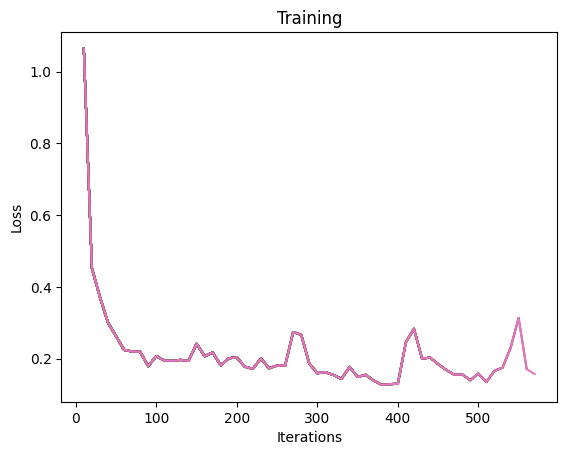

	 batch: 10, epoch: 2 | loss: 0.2995114
	 batch: 20, epoch: 2 | loss: 0.2189392
	 batch: 30, epoch: 2 | loss: 0.2209226
	 batch: 40, epoch: 2 | loss: 0.1990021
	 batch: 50, epoch: 2 | loss: 0.1639041
	 batch: 60, epoch: 2 | loss: 0.1529636
	 batch: 70, epoch: 2 | loss: 0.1605392
	 batch: 80, epoch: 2 | loss: 0.1618720
	 batch: 90, epoch: 2 | loss: 0.1346499
	 batch: 100, epoch: 2 | loss: 0.1609590
	 batch: 110, epoch: 2 | loss: 0.1472473
	 batch: 120, epoch: 2 | loss: 0.1490200
	 batch: 130, epoch: 2 | loss: 0.1591839
	 batch: 140, epoch: 2 | loss: 0.1513768
	 batch: 150, epoch: 2 | loss: 0.1909477
	 batch: 160, epoch: 2 | loss: 0.1666800
	 batch: 170, epoch: 2 | loss: 0.1801893
	 batch: 180, epoch: 2 | loss: 0.1496061
	 batch: 190, epoch: 2 | loss: 0.1694801
	 batch: 200, epoch: 2 | loss: 0.1737211
	 batch: 210, epoch: 2 | loss: 0.1503947
	 batch: 220, epoch: 2 | loss: 0.1468146
	 batch: 230, epoch: 2 | loss: 0.1785971
	 batch: 240, epoch: 2 | loss: 0.1547695
	 batch: 250, epoch: 2 | 

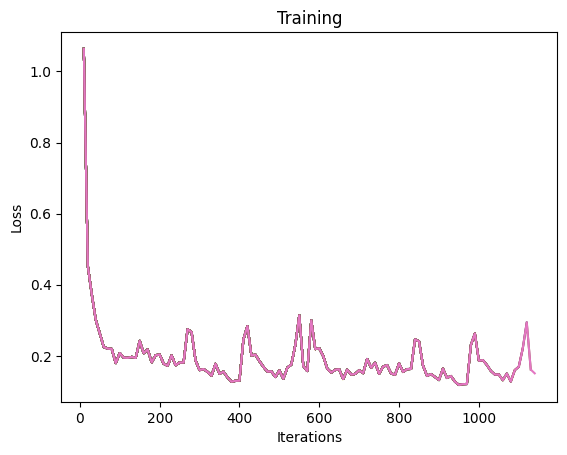

	 batch: 10, epoch: 3 | loss: 0.2833989
	 batch: 20, epoch: 3 | loss: 0.2096267
	 batch: 30, epoch: 3 | loss: 0.2142961
	 batch: 40, epoch: 3 | loss: 0.1903385
	 batch: 50, epoch: 3 | loss: 0.1564039
	 batch: 60, epoch: 3 | loss: 0.1488287
	 batch: 70, epoch: 3 | loss: 0.1555018
	 batch: 80, epoch: 3 | loss: 0.1551725
	 batch: 90, epoch: 3 | loss: 0.1290437
	 batch: 100, epoch: 3 | loss: 0.1542430
	 batch: 110, epoch: 3 | loss: 0.1401799
	 batch: 120, epoch: 3 | loss: 0.1408658
	 batch: 130, epoch: 3 | loss: 0.1523297
	 batch: 140, epoch: 3 | loss: 0.1443796
	 batch: 150, epoch: 3 | loss: 0.1838840
	 batch: 160, epoch: 3 | loss: 0.1606093
	 batch: 170, epoch: 3 | loss: 0.1735645
	 batch: 180, epoch: 3 | loss: 0.1441225
	 batch: 190, epoch: 3 | loss: 0.1611853
	 batch: 200, epoch: 3 | loss: 0.1665974
	 batch: 210, epoch: 3 | loss: 0.1441215
	 batch: 220, epoch: 3 | loss: 0.1428179
	 batch: 230, epoch: 3 | loss: 0.1742315
	 batch: 240, epoch: 3 | loss: 0.1510222
	 batch: 250, epoch: 3 | 

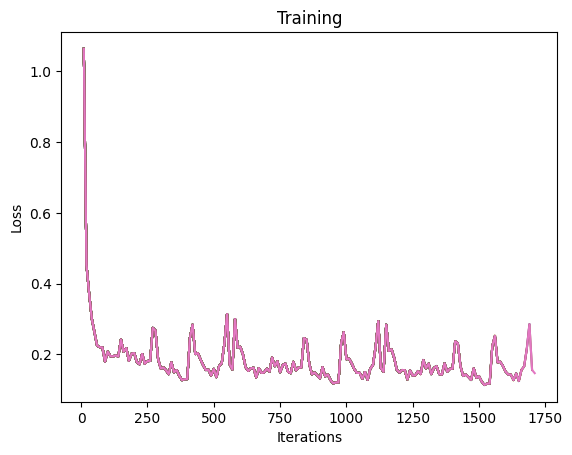

	 batch: 10, epoch: 4 | loss: 0.2698720
	 batch: 20, epoch: 4 | loss: 0.2043623
	 batch: 30, epoch: 4 | loss: 0.2094504
	 batch: 40, epoch: 4 | loss: 0.1848463
	 batch: 50, epoch: 4 | loss: 0.1515834
	 batch: 60, epoch: 4 | loss: 0.1461145
	 batch: 70, epoch: 4 | loss: 0.1526619
	 batch: 80, epoch: 4 | loss: 0.1502870
	 batch: 90, epoch: 4 | loss: 0.1258942
	 batch: 100, epoch: 4 | loss: 0.1482052
	 batch: 110, epoch: 4 | loss: 0.1366396
	 batch: 120, epoch: 4 | loss: 0.1368603
	 batch: 130, epoch: 4 | loss: 0.1482044
	 batch: 140, epoch: 4 | loss: 0.1392939
	 batch: 150, epoch: 4 | loss: 0.1789479
	 batch: 160, epoch: 4 | loss: 0.1559827
	 batch: 170, epoch: 4 | loss: 0.1705474
	 batch: 180, epoch: 4 | loss: 0.1408147
	 batch: 190, epoch: 4 | loss: 0.1553922
	 batch: 200, epoch: 4 | loss: 0.1608111
	 batch: 210, epoch: 4 | loss: 0.1413201
	 batch: 220, epoch: 4 | loss: 0.1408052
	 batch: 230, epoch: 4 | loss: 0.1705934
	 batch: 240, epoch: 4 | loss: 0.1472069
	 batch: 250, epoch: 4 | 

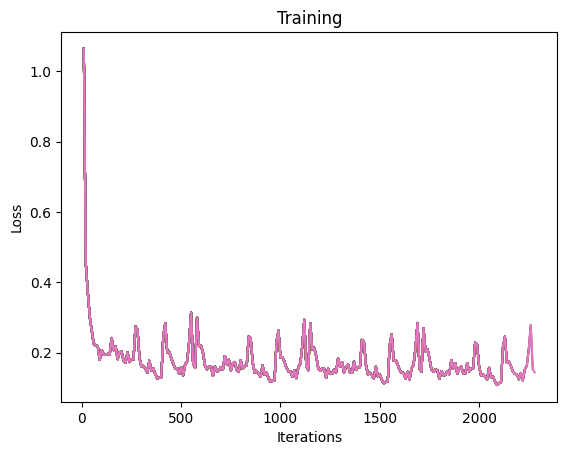

	 batch: 10, epoch: 5 | loss: 0.2609976
	 batch: 20, epoch: 5 | loss: 0.2007145
	 batch: 30, epoch: 5 | loss: 0.2061262
	 batch: 40, epoch: 5 | loss: 0.1807490
	 batch: 50, epoch: 5 | loss: 0.1477789
	 batch: 60, epoch: 5 | loss: 0.1437150
	 batch: 70, epoch: 5 | loss: 0.1506471
	 batch: 80, epoch: 5 | loss: 0.1470244
	 batch: 90, epoch: 5 | loss: 0.1247490
	 batch: 100, epoch: 5 | loss: 0.1446159
	 batch: 110, epoch: 5 | loss: 0.1339152
	 batch: 120, epoch: 5 | loss: 0.1339805
	 batch: 130, epoch: 5 | loss: 0.1439348
	 batch: 140, epoch: 5 | loss: 0.1358370
	 batch: 150, epoch: 5 | loss: 0.1749358
	 batch: 160, epoch: 5 | loss: 0.1528372
	 batch: 170, epoch: 5 | loss: 0.1675930
	 batch: 180, epoch: 5 | loss: 0.1367700
	 batch: 190, epoch: 5 | loss: 0.1522215
	 batch: 200, epoch: 5 | loss: 0.1577192
	 batch: 210, epoch: 5 | loss: 0.1400255
	 batch: 220, epoch: 5 | loss: 0.1385537
	 batch: 230, epoch: 5 | loss: 0.1667494
	 batch: 240, epoch: 5 | loss: 0.1431999
	 batch: 250, epoch: 5 | 

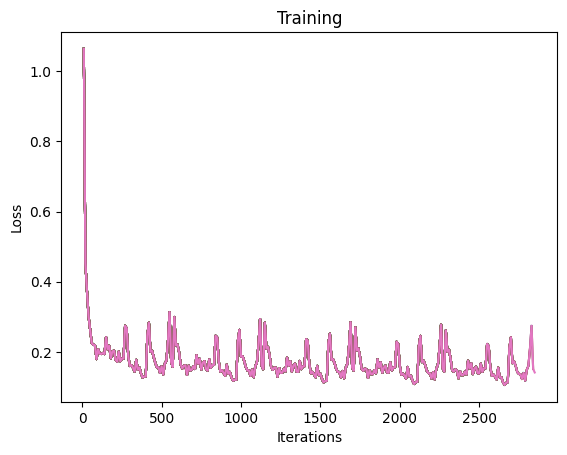

	 batch: 10, epoch: 6 | loss: 0.2553913
	 batch: 20, epoch: 6 | loss: 0.1980264
	 batch: 30, epoch: 6 | loss: 0.2032279
	 batch: 40, epoch: 6 | loss: 0.1779389
	 batch: 50, epoch: 6 | loss: 0.1451366
	 batch: 60, epoch: 6 | loss: 0.1412059
	 batch: 70, epoch: 6 | loss: 0.1481218
	 batch: 80, epoch: 6 | loss: 0.1445016
	 batch: 90, epoch: 6 | loss: 0.1235055
	 batch: 100, epoch: 6 | loss: 0.1414023
	 batch: 110, epoch: 6 | loss: 0.1312448
	 batch: 120, epoch: 6 | loss: 0.1325164
	 batch: 130, epoch: 6 | loss: 0.1420538
	 batch: 140, epoch: 6 | loss: 0.1344709
	 batch: 150, epoch: 6 | loss: 0.1748711
	 batch: 160, epoch: 6 | loss: 0.1536857
	 batch: 170, epoch: 6 | loss: 0.1621221
	 batch: 180, epoch: 6 | loss: 0.1337900
	 batch: 190, epoch: 6 | loss: 0.1488859
	 batch: 200, epoch: 6 | loss: 0.1551869
	 batch: 210, epoch: 6 | loss: 0.1383308
	 batch: 220, epoch: 6 | loss: 0.1355849
	 batch: 230, epoch: 6 | loss: 0.1648414
	 batch: 240, epoch: 6 | loss: 0.1404080
	 batch: 250, epoch: 6 | 

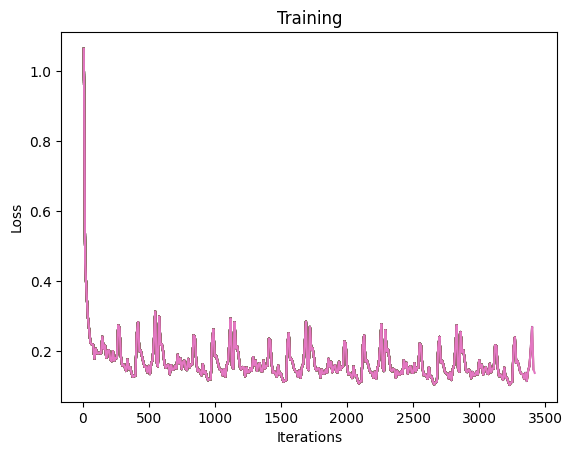

In [71]:
# training
avg_losses = []
iterations = []

best_val_loss = float('inf')
current_patience = 0
for epoch in range(epochs):
        train_loss = []
        micn_model.train()

        for i, (batch_x,batch_y,batch_x_ts,batch_y_ts) in enumerate(train_loader):
            if (batch_x.shape[0] != batch_size):
                continue

            optimizer.zero_grad()

            pred_padding = torch.zeros([batch_y.shape[0], output_length-w_len, batch_y.shape[-1]]).float()
            pre_in = torch.cat([batch_y[:,:w_len,:], pred_padding], dim=1).float()

            forecasting_dim = -1 if forecasting_type == 'MS' else 0
            y_pred = micn_model(batch_x, batch_x_ts, pre_in, batch_y_ts)[:,:,forecasting_dim:]
            y = batch_y[:,-output_length:,forecasting_dim:]

            loss = loss_function(y_pred, y)
            train_loss.append(loss.item())

            if (i+1) % 10 == 0:
                iterations.append((epoch*570)+(i+1))
                avg_loss = np.average(train_loss)

                avg_losses.append(avg_loss)
                train_loss = []

                print("\t batch: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, avg_loss))

                plt.xlabel('Iterations')
                plt.ylabel('Loss')
                plt.title("Training")
                plt.plot(iterations, avg_losses)


            loss.backward()
            optimizer.step()

        val_loss = validation(micn_model, val_dataset, val_loader, loss_function)
        print("\t  epoch: {0} | validation loss: {1:.7f}".format(epoch + 1, val_loss))
        stop_training, best_val_loss, current_patience = early_stopping(micn_model, patience, val_loss, best_val_loss, current_patience)

        if stop_training:
            torch.save(micn_model.state_dict(), model_weights)
            plt.show()
            plt.savefig('training.png')
            print("Early stopping at epoch: "+str(epoch))
            break

        plt.show()

torch.save(micn_model.state_dict(), model_weights)

In [72]:
def plot_last_feature_comparison(y, y_pred):
    if not isinstance(y, torch.Tensor) or not isinstance(y_pred, torch.Tensor):
        raise ValueError("Entrambi gli input devono essere tensori PyTorch")

    # exctract the last feature 'OT' from the tensors
    y_OT = y[:, :, -1]
    y_pred_OT = y_pred[:, :, -1]

    # turn the tensors into numpy arrays and reshape them
    y_OT_np = y_OT.cpu().numpy()
    y_pred_OT_np = y_pred_OT.cpu().numpy()

    y_OT_flat = y_OT_np.reshape(-1)
    y_pred_OT_flat = y_pred_OT_np.reshape(-1)

    # create a dataframe per Seaborn
    df = pd.DataFrame({'Real': y_OT_flat, 'Predicted': y_pred_OT_flat})

    # pot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, palette=['blue', 'orange'])
    plt.title('Comparison between the real and the predicted output')
    plt.xlabel('Samples')
    plt.ylabel('Target Value (OT)')
    plt.show()

	 batch: 1, loss: 0.1553865


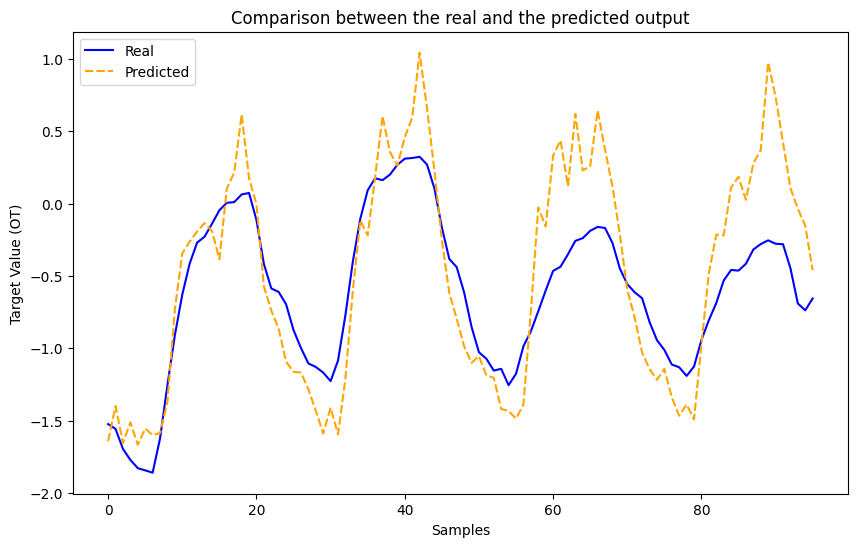

	 batch: 2, loss: 0.1539156
	 batch: 3, loss: 0.1944200
	 batch: 4, loss: 0.2293484
	 batch: 5, loss: 0.1947774
	 batch: 6, loss: 0.1737444
	 batch: 7, loss: 0.1615902
	 batch: 8, loss: 0.1677605
	 batch: 9, loss: 0.2190078
	 batch: 10, loss: 0.1970057
	 batch: 11, loss: 0.2109828
	 batch: 12, loss: 0.2630709
	 batch: 13, loss: 0.3134459
	 batch: 14, loss: 0.3516202
	 batch: 15, loss: 0.2772392
	 batch: 16, loss: 0.2353420
	 batch: 17, loss: 0.1998617
	 batch: 18, loss: 0.1830651
	 batch: 19, loss: 0.2231641
	 batch: 20, loss: 0.2214366
	 batch: 21, loss: 0.1917626
	 batch: 22, loss: 0.1841910
	 batch: 23, loss: 0.1808974
	 batch: 24, loss: 0.2016705
	 batch: 25, loss: 0.2314385
	 batch: 26, loss: 0.1928528
	 batch: 27, loss: 0.1785653
	 batch: 28, loss: 0.1847691
	 batch: 29, loss: 0.1971711
	 batch: 30, loss: 0.2448556
	 batch: 31, loss: 0.2178247


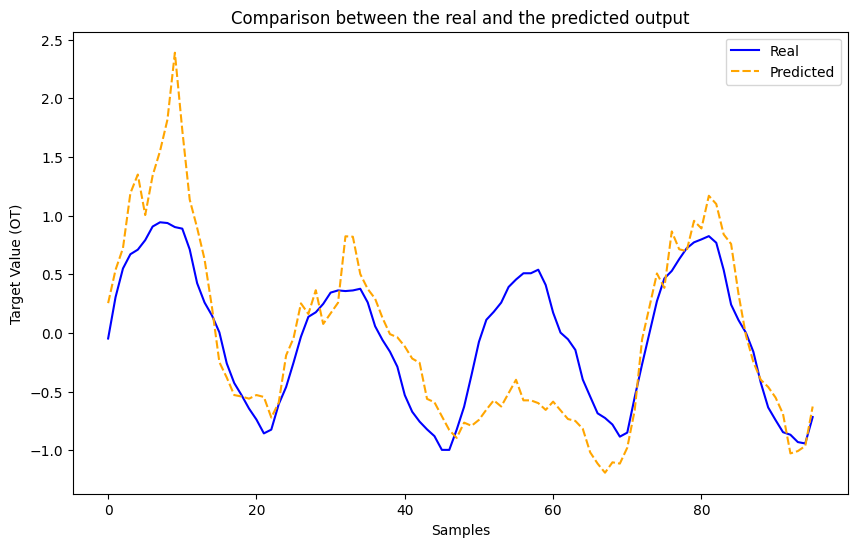

	 batch: 32, loss: 0.2108320
	 batch: 33, loss: 0.2441961
	 batch: 34, loss: 0.2782033
	 batch: 35, loss: 0.3143896
	 batch: 36, loss: 0.2708074
	 batch: 37, loss: 0.2731647
	 batch: 38, loss: 0.2698448
	 batch: 39, loss: 0.2380332
	 batch: 40, loss: 0.2816939
	 batch: 41, loss: 0.2817614
	 batch: 42, loss: 0.2514465
	 batch: 43, loss: 0.2315088
	 batch: 44, loss: 0.2313945
	 batch: 45, loss: 0.2687862
	 batch: 46, loss: 0.2934150
	 batch: 47, loss: 0.2873834
	 batch: 48, loss: 0.2925270
	 batch: 49, loss: 0.2576902
	 batch: 50, loss: 0.2658258
	 batch: 51, loss: 0.3294573
	 batch: 52, loss: 0.2645944
	 batch: 53, loss: 0.2563061
	 batch: 54, loss: 0.2637342
	 batch: 55, loss: 0.2764172
	 batch: 56, loss: 0.3250317
	 batch: 57, loss: 0.2810096
	 batch: 58, loss: 0.2463365
	 batch: 59, loss: 0.2278003
	 batch: 60, loss: 0.2459955
	 batch: 61, loss: 0.2911288


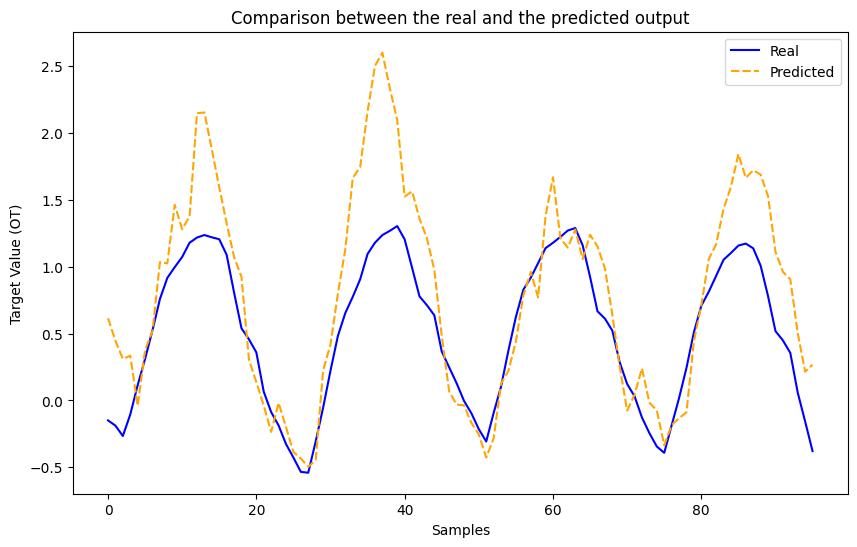

	 batch: 62, loss: 0.2994179
	 batch: 63, loss: 0.2754686
	 batch: 64, loss: 0.2403861
	 batch: 65, loss: 0.2224954
	 batch: 66, loss: 0.2318635
	 batch: 67, loss: 0.2572001
	 batch: 68, loss: 0.2587708
	 batch: 69, loss: 0.2689078
	 batch: 70, loss: 0.2428476
	 batch: 71, loss: 0.2251852
	 batch: 72, loss: 0.2635361
	 batch: 73, loss: 0.2744445
	 batch: 74, loss: 0.2606485
	 batch: 75, loss: 0.2240160
	 batch: 76, loss: 0.2158149
	 batch: 77, loss: 0.2696992
	 batch: 78, loss: 0.2360536
	 batch: 79, loss: 0.2140409
	 batch: 80, loss: 0.1966940
	 batch: 81, loss: 0.1922887
	 batch: 82, loss: 0.2426193
	 batch: 83, loss: 0.2355345
	 batch: 84, loss: 0.2017005
	 batch: 85, loss: 0.1763157
	 batch: 86, loss: 0.1558110
	 batch: 87, loss: 0.1829447
	 batch: 88, loss: 0.2183594
	 batch: 89, loss: 0.1830767
	 batch: 90, loss: 0.1665564
	 batch: 91, loss: 0.1562668


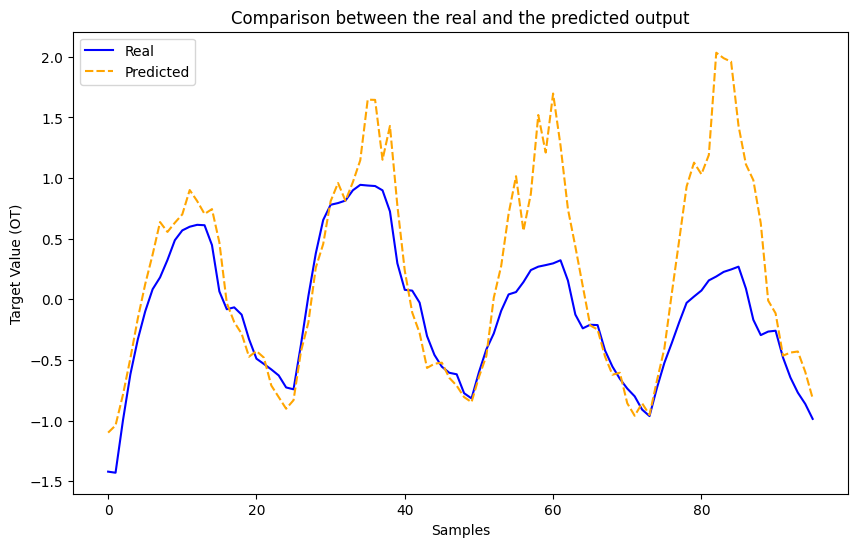

	 batch: 92, loss: 0.1697676
	 batch: 93, loss: 0.2178905
	 batch: 94, loss: 0.1851291
	 batch: 95, loss: 0.1737031
	 batch: 96, loss: 0.1897286
	 batch: 97, loss: 0.1843755
	 batch: 98, loss: 0.2167299
	 batch: 99, loss: 0.1869351
	 batch: 100, loss: 0.1753583
	 batch: 101, loss: 0.1638839
	 batch: 102, loss: 0.1459452
	 batch: 103, loss: 0.1812598
	 batch: 104, loss: 0.1810739
	 batch: 105, loss: 0.1598892
	 batch: 106, loss: 0.1694100
	 batch: 107, loss: 0.1601515
	 batch: 108, loss: 0.1772876
	 batch: 109, loss: 0.2233070
	 batch: 110, loss: 0.2051423
	 batch: 111, loss: 0.1924561
	 batch: 112, loss: 0.1825522
	 batch: 113, loss: 0.2002530
	 batch: 114, loss: 0.2836976
	 batch: 115, loss: 0.2547750
	 batch: 116, loss: 0.2122022
	 batch: 117, loss: 0.1591366
	 batch: 118, loss: 0.1494680
	 batch: 119, loss: 0.1950244
	 batch: 120, loss: 0.1710561
	 batch: 121, loss: 0.1592125


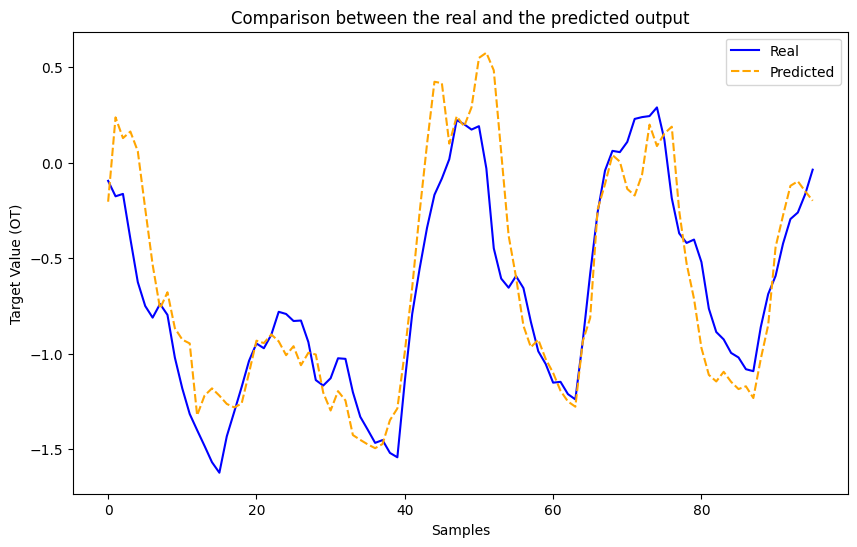

	 batch: 122, loss: 0.1447740
	 batch: 123, loss: 0.1311384
	 batch: 124, loss: 0.1701091
	 batch: 125, loss: 0.1698125
	 batch: 126, loss: 0.1474442
	 batch: 127, loss: 0.1361768
	 batch: 128, loss: 0.1318398
	 batch: 129, loss: 0.1553911
	 batch: 130, loss: 0.1768152
	 batch: 131, loss: 0.1560859
	 batch: 132, loss: 0.1420177
	 batch: 133, loss: 0.1344864
	 batch: 134, loss: 0.1379256
	 batch: 135, loss: 0.1839892
	 batch: 136, loss: 0.1588513
	 batch: 137, loss: 0.1476098
	 batch: 138, loss: 0.1420396
	 batch: 139, loss: 0.1340224
	 batch: 140, loss: 0.1804471
	 batch: 141, loss: 0.1590914
	 batch: 142, loss: 0.1785347
	 batch: 143, loss: 0.1624600
	 batch: 144, loss: 0.1473936
	 batch: 145, loss: 0.1850560
	 batch: 146, loss: 0.1860596
	 batch: 147, loss: 0.1689604
	 batch: 148, loss: 0.1743931
	 batch: 149, loss: 0.1605665
	 batch: 150, loss: 0.1811901
	 batch: 151, loss: 0.1975905


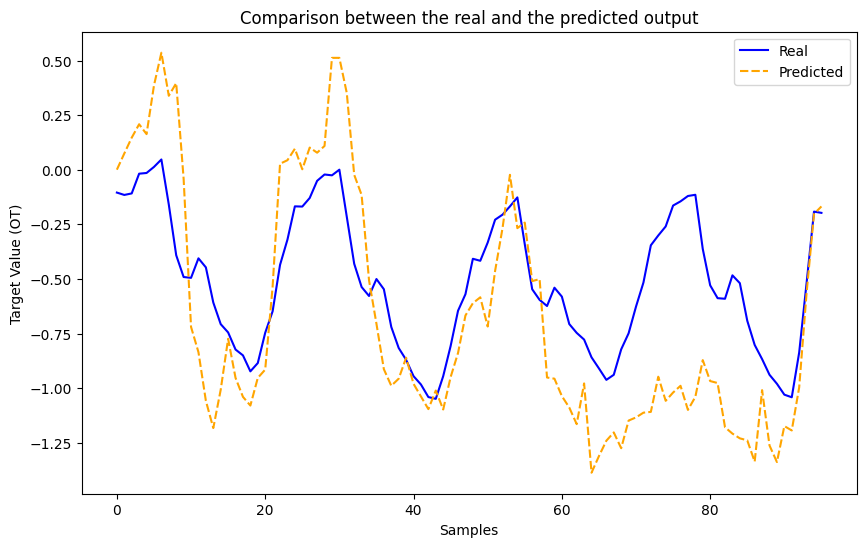

	 batch: 152, loss: 0.1767031
	 batch: 153, loss: 0.1581225
	 batch: 154, loss: 0.1560300
	 batch: 155, loss: 0.1742028
	 batch: 156, loss: 0.2116540
	 batch: 157, loss: 0.1819922
	 batch: 158, loss: 0.2172328
	 batch: 159, loss: 0.6251479
	 batch: 160, loss: 0.4653570
	 batch: 161, loss: 0.3185944
	 batch: 162, loss: 0.2191218


In [73]:
def test(model, loss_function, model_weights, test_loader):
      model.load_state_dict(torch.load(model_weights))

      model.eval()
      loss_function = loss_function

      predictions = []
      ground_truth = []

      for i, (batch_x,batch_y,batch_x_ts,batch_y_ts) in enumerate(test_loader):

          pred_padding = torch.zeros([batch_y.shape[0], w_len, batch_y.shape[-1]]).float()
          pre_in = torch.cat([batch_y[:,:w_len,:], pred_padding], dim=1).float()

          forecasting_dim = -1 if forecasting_type == 'MS' else 0
          y_pred = micn_model(batch_x, batch_x_ts, pre_in, batch_y_ts)[:,:,forecasting_dim:]
          y = batch_y[:,-output_length:,forecasting_dim:]

          loss = loss_function(y_pred, y)
          print("\t batch: {0}, loss: {1:.7f}".format(i + 1, loss))

          #every 30 iterations chose randomply a sample and plot the comparison between the prediction and the ground truth
          if (i%30 == 0):
            random_sample = np.random.randint(0, batch_size-1)
            y_example = y_pred[random_sample:random_sample+1,:,:].detach()
            y_pred_example = y[random_sample:random_sample+1,:,:].detach()
            plot_last_feature_comparison(y_example, y_pred_example)

      return

micn_model_test = MICN(conv_kernel, isometric_kernel, channel_in, channel_out, dropout)
testing = test(micn_model_test, loss_function, model_weights, test_loader)
testing